In [1]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
#from sklearn import joblib
import pandas as pd 
from pandas import concat
import numpy as np
from numpy import cov
from datetime import datetime
from scipy import interp
#from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.callbacks import TensorBoard
from keras.optimizers import Adam, Adadelta
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler 
from sklearn.pipeline import Pipeline

seed = 7
np.random.seed(seed)


Using TensorFlow backend.


In [2]:
dataset_16 = pd.read_csv('acelerometro_terra_16.csv')
dataset_gyro_16 = pd.read_csv('giroscopio_terra_16.csv')

#load ground truth
dataset_ground_16 = pd.read_csv('groundTruth_16.csv')

#rename ground truth
dataset_ground_16.columns = ['evento', ' inicio', ' fim']
dataset_ground_16 = dataset_ground_16.rename(columns = \
                                    {'evento':'event',' inicio':'start',' fim':'end'})

#rename acc and gyro dataset
dataset_16 = dataset_16.rename(columns = \
                               {'x':'acc_x','y':'acc_y','z':'acc_z'})
dataset_gyro_16 = dataset_gyro_16.rename(columns = \
                               {'x':'gyro_x','y':'gyro_y','z':'gyro_z'})
#merge acc and gyro data
dataset_acc_gyro_16 = pd.merge(dataset_16, dataset_gyro_16, left_index=True, right_index=True)


#calculate second
s = dataset_acc_gyro_16.iloc[ 0 , 1 ]
dataset_acc_gyro_16['second'] = (dataset_16.iloc[:,1]-s)/pow(10,9)


dataset_acc_gyro_16['time'] = dataset_acc_gyro_16['second']

del dataset_acc_gyro_16['uptimeNanos_x']
del dataset_acc_gyro_16['uptimeNanos_y']
del dataset_acc_gyro_16['timestamp_x']
del dataset_acc_gyro_16['timestamp_y']

xyz = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']

dataset_acc_gyro_16[xyz] = dataset_acc_gyro_16[xyz].astype('float64')
dataset_acc_gyro_16

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,second,time
0,-0.161602,0.120174,9.596758,-0.070372,0.000844,0.029619,0.000000,0.000000
1,-0.122628,0.315638,9.425655,-0.058695,0.009130,0.024406,0.009858,0.009858
2,-0.178777,0.330180,9.445955,0.006625,-0.002283,-0.015018,0.019625,0.019625
3,0.016043,0.038759,9.528445,0.064933,0.033172,-0.040503,0.039280,0.039280
4,0.141716,-0.162492,9.756854,0.039454,-0.013078,-0.007681,0.058935,0.058935
...,...,...,...,...,...,...,...,...
64640,-0.462898,-0.330468,9.026200,-0.194610,0.150351,-0.012446,1269.001984,1269.001984
64641,0.274546,0.864909,10.338760,-0.167431,0.199986,0.020079,1269.021608,1269.021608
64642,0.711429,0.930382,10.992975,0.064197,0.053792,0.079096,1269.041202,1269.041202
64643,0.674247,-0.342384,9.904447,0.179586,-0.106454,0.048294,1269.060796,1269.060796


In [3]:
dataset_ground_16['event'] = dataset_ground_16['event'].map({'evento_nao_agressivo': 'non_aggressive', \
'curva_direita_agressiva':'aggressive_right_turn',\
'curva_esquerda_agressiva':'aggressive_left_turn',\
'troca_faixa_esquerda_agressiva':'aggressive_left_lane_change',\
'freada_agressiva': 'aggressive_braking', 'aceleracao_agressiva': 'aggressive_acceleration',\
'troca_faixa_direita_agressiva':'aggressive_right_lane_change'})

dataset_ground_16

,event,start,end
0,non_aggressive,2.0,6.5
1,aggressive_right_turn,19.5,23.5
2,non_aggressive,30.0,33.5
3,aggressive_right_turn,95.0,98.0
4,aggressive_left_turn,247.0,251.5
5,aggressive_left_turn,348.7,352.3
6,non_aggressive,485.0,489.0
7,aggressive_left_turn,496.0,499.5
8,aggressive_right_turn,587.0,590.0
9,aggressive_left_turn,750.0,753.8


In [4]:
dataset_17 = pd.read_csv('acelerometro_terra_17.csv')
dataset_gyro_17 = pd.read_csv('giroscopio_terra_17.csv')

dataset_ground_17 = pd.read_csv('groundTruth_17.csv')

dataset_ground_17.columns = ['evento', ' inicio', ' fim']
dataset_ground_17 = dataset_ground_17.rename(columns = \
                                    {'evento':'event',' inicio':'start',' fim':'end'})

#rename acc and gyro dataset
dataset_17 = dataset_17.rename(columns = \
                               {'x':'acc_x','y':'acc_y','z':'acc_z'})
dataset_gyro_17 = dataset_gyro_17.rename(columns = \
                               {'x':'gyro_x','y':'gyro_y','z':'gyro_z'})

dataset_acc_gyro_17 = pd.merge(dataset_17, dataset_gyro_17, left_index=True, right_index=True)

p = dataset_acc_gyro_17.iloc[ 0 , 1 ]
dataset_acc_gyro_17['second'] = (dataset_17.iloc[:,1]-p)/pow(10,9)
dataset_acc_gyro_17['second'] = dataset_acc_gyro_17['second']+dataset_acc_gyro_16["second"].iloc[-1]

dataset_acc_gyro_17['time'] = dataset_acc_gyro_17['second']

del dataset_acc_gyro_17['uptimeNanos_x']
del dataset_acc_gyro_17['uptimeNanos_y']
del dataset_acc_gyro_17['timestamp_x']
del dataset_acc_gyro_17['timestamp_y']

xyz = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']

dataset_acc_gyro_17[xyz] = dataset_acc_gyro_17[xyz].astype('float64')
dataset_acc_gyro_17


,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,second,time
0,-0.047600,0.004670,9.852109,0.030578,-0.035392,-0.033423,1269.080574,1269.080574
1,-0.066993,0.060984,9.634208,-0.007943,-0.017933,-0.022102,1269.089943,1269.089943
2,-0.200131,0.170454,9.512366,-0.005299,-0.041667,-0.008381,1269.100168,1269.100168
3,-0.185315,-0.039818,9.671576,0.020004,0.012221,0.001138,1269.119823,1269.119823
4,-0.011559,0.049461,9.844943,-0.025175,0.020601,0.023692,1269.139386,1269.139386
...,...,...,...,...,...,...,...,...
20670,-0.005218,0.820041,9.761320,0.069331,0.021811,0.026484,1674.838455,1674.838455
20671,0.190040,0.497128,9.849915,0.056989,0.004142,-0.066499,1674.858111,1674.858111
20672,0.316982,0.575736,9.766142,0.078091,0.044875,0.014208,1674.877949,1674.877949
20673,0.213982,0.827790,10.236000,0.060844,0.013695,-0.002162,1674.897390,1674.897390


In [5]:
dataset_ground_17['event'] = dataset_ground_17['event'].map({'evento_nao_agressivo': 'non_aggressive', \
'curva_direita_agressiva':'aggressive_right_turn',\
'curva_esquerda_agressiva':'aggressive_left_turn',\
'troca_faixa_esquerda_agressiva':'aggressive_left_lane_change',\
'freada_agressiva': 'aggressive_braking', 'aceleracao_agressiva': 'aggressive_acceleration',\
'troca_faixa_direita_agressiva':'aggressive_right_lane_change'})

dataset_ground_17['start'] = dataset_ground_17['start']+\
                                    dataset_acc_gyro_16["second"].iloc[-1]
dataset_ground_17['end'] = dataset_ground_17['end'] +\
                                    dataset_acc_gyro_16["second"].iloc[-1]

dataset_ground_17

,event,start,end
0,aggressive_right_lane_change,1285.180574,1287.580574
1,aggressive_right_lane_change,1294.180574,1296.680574
2,aggressive_braking,1410.080574,1412.380574
3,aggressive_braking,1420.380574,1422.280574
4,aggressive_braking,1434.980574,1437.080574
5,aggressive_braking,1489.680574,1491.680574
6,aggressive_braking,1503.080574,1505.280574
7,aggressive_braking,1517.180574,1519.880574
8,aggressive_acceleration,1557.080574,1559.680574
9,aggressive_acceleration,1573.680574,1577.280574


In [6]:
dataset_20 = pd.read_csv('acelerometro_terra_20.csv')
dataset_gyro_20 = pd.read_csv('giroscopio_terra_20.csv')
dataset_ground_20 = pd.read_csv('groundTruth_20.csv')

dataset_ground_20.columns = ['evento', ' inicio', ' fim']
dataset_ground_20 = dataset_ground_20.rename(columns = \
                                    {'evento':'event',' inicio':'start',' fim':'end'})

#rename acc and gyro dataset
dataset_20 = dataset_20.rename(columns = \
                               {'x':'acc_x','y':'acc_y','z':'acc_z'})
dataset_gyro_20 = dataset_gyro_20.rename(columns = \
                               {'x':'gyro_x','y':'gyro_y','z':'gyro_z'})

dataset_acc_gyro_20 = pd.merge(dataset_20, dataset_gyro_20, left_index=True, right_index=True)

q = dataset_acc_gyro_20.iloc[ 0 , 1 ]
dataset_acc_gyro_20['second'] = (dataset_20.iloc[:,1]-q)/pow(10,9)
dataset_acc_gyro_20['second'] = dataset_acc_gyro_20['second']+dataset_acc_gyro_17["second"].iloc[-1]

dataset_acc_gyro_20['time'] = dataset_acc_gyro_20['second']

dataset_20['timestamp'] = pd.to_datetime(dataset_20.timestamp)

dataset_acc_gyro_20['time'] = dataset_acc_gyro_20['second']

del dataset_acc_gyro_20['uptimeNanos_x']
del dataset_acc_gyro_20['uptimeNanos_y']
del dataset_acc_gyro_20['timestamp_x']
del dataset_acc_gyro_20['timestamp_y']

xyz = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']

dataset_acc_gyro_20[xyz] = dataset_acc_gyro_20[xyz].astype('float64')
dataset_acc_gyro_20

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,second,time
0,-0.080265,-0.333322,9.830113,0.024461,0.011438,-0.064492,1674.917045,1674.917045
1,-0.154129,-0.448813,9.740011,-0.016953,-0.011038,-0.055165,1674.926446,1674.926446
2,-0.095645,-0.264550,9.761985,-0.024161,0.030720,-0.074291,1674.936670,1674.936670
3,0.099183,-0.002997,9.403379,-0.053002,0.019353,-0.055249,1674.956264,1674.956264
4,-0.062966,-0.125343,9.507346,0.038197,0.013342,-0.063427,1674.975889,1674.975889
...,...,...,...,...,...,...,...,...
30009,0.452141,0.537593,10.324424,0.021691,0.021512,0.063855,2263.953243,2263.953243
30010,0.177943,0.112586,10.019398,0.094567,-0.076470,0.047504,2263.972837,2263.972837
30011,-0.136197,-0.672558,9.376661,0.120387,-0.120189,0.045391,2263.992461,2263.992461
30012,-0.087675,-0.311449,9.269219,-0.016974,-0.017694,-0.015368,2264.012147,2264.012147


In [7]:
dataset_ground_20['event'] = dataset_ground_20['event'].map({'evento_nao_agressivo': 'non_aggressive', \
'curva_direita_agressiva':'aggressive_right_turn',\
'curva_esquerda_agressiva':'aggressive_left_turn',\
'troca_faixa_esquerda_agressiva':'aggressive_left_lane_change',\
'freada_agressiva': 'aggressive_braking', 'aceleracao_agressiva': 'aggressive_acceleration',\
'troca_faixa_direita_agressiva':'aggressive_right_lane_change'})

dataset_ground_20['start'] = dataset_ground_20['start']+\
                                    dataset_acc_gyro_17["second"].iloc[-1]
dataset_ground_20['end'] = dataset_ground_20['end'] +\
                                    dataset_acc_gyro_17["second"].iloc[-1]

dataset_ground_20

,event,start,end
0,aggressive_right_turn,1684.417045,1687.417045
1,non_aggressive,1693.917045,1697.917045
2,aggressive_right_turn,1766.517045,1769.817045
3,aggressive_right_turn,1795.817045,1799.017045
4,aggressive_right_turn,1810.317045,1813.917045
5,non_aggressive,1838.917045,1842.917045
6,non_aggressive,1861.917045,1865.417045
7,aggressive_right_turn,1894.317045,1898.817045
8,aggressive_right_turn,1907.517045,1911.617045
9,non_aggressive,2032.917045,2035.417045


In [8]:
dataset_21 = pd.read_csv('acelerometro_terra_21.csv')
dataset_gyro_21 = pd.read_csv('giroscopio_terra_21.csv')
dataset_ground_21 = pd.read_csv('groundTruth_21.csv')


dataset_ground_21.columns = ['evento', ' inicio', ' fim']
dataset_ground_21 = dataset_ground_21.rename(columns = \
                                    {'evento':'event',' inicio':'start',' fim':'end'})

#rename acc and gyro dataset
dataset_21 = dataset_21.rename(columns = \
                               {'x':'acc_x','y':'acc_y','z':'acc_z'})
dataset_gyro_21 = dataset_gyro_21.rename(columns = \
                               {'x':'gyro_x','y':'gyro_y','z':'gyro_z'})

dataset_acc_gyro_21 = pd.merge(dataset_21, dataset_gyro_21, left_index=True, right_index=True)

r = dataset_acc_gyro_21.iloc[ 0 , 1 ]
dataset_acc_gyro_21['second'] = (dataset_21.iloc[:,1]-r)/pow(10,9)
dataset_acc_gyro_21['second'] = dataset_acc_gyro_21['second']+dataset_acc_gyro_20["second"].iloc[-1]

dataset_21['timestamp'] = pd.to_datetime(dataset_21.timestamp)

dataset_acc_gyro_21['time'] = dataset_acc_gyro_21['second']

del dataset_acc_gyro_21['uptimeNanos_x']
del dataset_acc_gyro_21['uptimeNanos_y']
del dataset_acc_gyro_21['timestamp_x']
del dataset_acc_gyro_21['timestamp_y']

dataset_acc_gyro_21[xyz] = dataset_acc_gyro_21[xyz].astype('float64')
dataset_acc_gyro = dataset_acc_gyro_21
dataset_acc_gyro

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,second,time
0,0.336558,-0.169031,9.658637,0.031439,0.360042,0.009180,2264.032077,2264.032077
1,2.022178,-0.125877,9.948004,0.235446,0.680577,-0.039432,2264.042240,2264.042240
2,0.777634,-0.088642,11.809340,0.118159,0.084886,-0.087033,2264.061956,2264.061956
3,-0.695542,-0.127862,8.672421,-0.176048,-0.288289,0.070482,2264.081581,2264.081581
4,-1.864220,0.843311,8.023548,-0.137060,-0.123618,0.051219,2264.101205,2264.101205
...,...,...,...,...,...,...,...,...
41173,-1.774155,0.323906,9.034099,-0.151247,-0.396103,0.080793,3072.286555,3072.286555
41174,-1.339564,0.689762,8.233537,-0.072395,-0.177360,-0.144552,3072.306088,3072.306088
41175,-0.927715,0.917821,8.971828,0.071834,0.070415,-0.138477,3072.325805,3072.325805
41176,-1.334792,0.840206,9.529889,0.204297,0.217238,-0.105675,3072.345307,3072.345307


In [9]:
dataset_ground_21['event'] = dataset_ground_21['event'].map({'evento_nao_agressivo': 'non_aggressive', \
'curva_direita_agressiva':'aggressive_right_turn',\
'curva_esquerda_agressiva':'aggressive_left_turn',\
'troca_faixa_esquerda_agressiva':'aggressive_left_lane_change',\
'freada_agressiva': 'aggressive_braking', 'aceleracao_agressiva': 'aggressive_acceleration',\
'troca_faixa_direita_agressiva':'aggressive_right_lane_change'})

dataset_ground_21['start'] = dataset_ground_21['start']+\
                                    dataset_acc_gyro_20["second"].iloc[-1]
dataset_ground_21['end'] = dataset_ground_21['end'] +\
                                    dataset_acc_gyro_20["second"].iloc[-1]

dataset_ground_21

,event,start,end
0,non_aggressive,2299.032077,2302.632077
1,aggressive_left_lane_change,2287.132077,2288.732077
2,non_aggressive,2349.532077,2353.032077
3,aggressive_left_lane_change,2361.732077,2364.032077
4,aggressive_left_lane_change,2372.132077,2374.532077
5,non_aggressive,2381.032077,2385.032077
6,aggressive_left_lane_change,2427.332077,2429.432077
7,non_aggressive,2453.032077,2457.032077
8,aggressive_braking,2463.132077,2465.532077
9,aggressive_braking,2521.132077,2524.832077


In [10]:
dataset_acc_gyro_new = pd.concat([dataset_acc_gyro_16,dataset_acc_gyro_17], ignore_index=True)

dataset_acc_gyro_new = pd.concat([dataset_acc_gyro_new, dataset_acc_gyro_20], ignore_index=True)

dataset_acc_gyro_new = pd.concat([dataset_acc_gyro_new, dataset_acc_gyro_21], ignore_index=True)
dataset_acc_gyro = dataset_acc_gyro_new 
dataset_acc_gyro

dataset_ground_new = pd.concat([dataset_ground_16, dataset_ground_17], ignore_index=True)
dataset_ground_new

dataset_ground_new = pd.concat([dataset_ground_new, dataset_ground_20], ignore_index=True)
dataset_ground_new

dataset_ground_new = pd.concat([dataset_ground_new, dataset_ground_21], ignore_index=True)
dataset_ground = dataset_ground_new
dataset_ground[0:10]



,event,start,end
0,non_aggressive,2.0,6.5
1,aggressive_right_turn,19.5,23.5
2,non_aggressive,30.0,33.5
3,aggressive_right_turn,95.0,98.0
4,aggressive_left_turn,247.0,251.5
5,aggressive_left_turn,348.7,352.3
6,non_aggressive,485.0,489.0
7,aggressive_left_turn,496.0,499.5
8,aggressive_right_turn,587.0,590.0
9,aggressive_left_turn,750.0,753.8


In [11]:
dataset_acc_gyro['eng_acc_x'] = (dataset_acc_gyro['acc_x'].pow(2))
dataset_acc_gyro['eng_acc_y'] = (dataset_acc_gyro['acc_y'].pow(2))
dataset_acc_gyro['eng_gyro_z'] = (dataset_acc_gyro['gyro_z'].pow(2))

dataset_acc_gyro['slope_acc_x'] = dataset_acc_gyro.iloc[:, 0].diff().div(dataset_acc_gyro.second.diff(), axis=0)
dataset_acc_gyro['slope_acc_y'] = dataset_acc_gyro.iloc[:, 1].diff().div(dataset_acc_gyro.second.diff(), axis=0)
dataset_acc_gyro['slope_gyro_z'] = dataset_acc_gyro.iloc[:, 5].diff().div(dataset_acc_gyro.second.diff(), axis=0)

dataset_acc_gyro


,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,second,time,eng_acc_x,eng_acc_y,eng_gyro_z,slope_acc_x,slope_acc_y,slope_gyro_z
0,-0.161602,0.120174,9.596758,-0.070372,0.000844,0.029619,0.000000,0.000000,0.026115,0.014442,0.000877,NaN,NaN,NaN
1,-0.122628,0.315638,9.425655,-0.058695,0.009130,0.024406,0.009858,0.009858,0.015038,0.099627,0.000596,3.953507,19.827765,-0.528823
2,-0.178777,0.330180,9.445955,0.006625,-0.002283,-0.015018,0.019625,0.019625,0.031961,0.109019,0.000226,-5.749091,1.489036,-4.036665
3,0.016043,0.038759,9.528445,0.064933,0.033172,-0.040503,0.039280,0.039280,0.000257,0.001502,0.001641,9.911947,-14.826768,-1.296626
4,0.141716,-0.162492,9.756854,0.039454,-0.013078,-0.007681,0.058935,0.058935,0.020083,0.026404,0.000059,6.393871,-10.239105,1.669887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156507,-1.774155,0.323906,9.034099,-0.151247,-0.396103,0.080793,3072.286555,3072.286555,3.147626,0.104915,0.006528,-50.256347,-5.735833,-3.318942
156508,-1.339564,0.689762,8.233537,-0.072395,-0.177360,-0.144552,3072.306088,3072.306088,1.794431,0.475771,0.020895,22.249042,18.730069,-11.536591
156509,-0.927715,0.917821,8.971828,0.071834,0.070415,-0.138477,3072.325805,3072.325805,0.860656,0.842396,0.019176,20.888859,11.567147,0.308098
156510,-1.334792,0.840206,9.529889,0.204297,0.217238,-0.105675,3072.345307,3072.345307,1.781670,0.705946,0.011167,-20.873032,-3.979756,1.681947


In [12]:
list = []
for time in dataset_acc_gyro['second']:
    category = None
    count=-1
    for start,end in zip(dataset_ground['start'],dataset_ground['end']):
        count += 1
        flag = 0
        if (( time>=start) & (time <= end)):
            flag = 1
            break
    if ((count != -1) & (flag == 1)):
        category = dataset_ground.iloc[count]['event'] 
    else: 
        category = 'unlabeled'

    list.append(category)
    
dataset_acc_gyro['category']=list


In [13]:
indexNames = dataset_acc_gyro[ (dataset_acc_gyro['category'] == 'unlabeled') ].index
dataset_acc_gyro.drop(indexNames , inplace=True)
#dataset_acc_gyro

In [14]:
dataset_acc_gyro.set_index('second', inplace=True)

#window feature seclection for acc_x
acc_x = dataset_acc_gyro['acc_x']
shifted_acc_x = acc_x.shift(1)
window_shifted_acc_x = shifted_acc_x.rolling(window=20)
mean_window_acc_x = window_shifted_acc_x.mean().fillna(value =0, inplace=False)
#mean_window_acc_x = window_shifted_acc_x.mad()
min_window_acc_x = window_shifted_acc_x.min().fillna(value =0, inplace=False)
max_window_acc_x = window_shifted_acc_x.max().fillna(value =0, inplace=False)
var_window_acc_x = window_shifted_acc_x.var().fillna(value =0, inplace=False)
std_window_acc_x = window_shifted_acc_x.std().fillna(value =0, inplace=False)
#NAN value replace by zero
#https://stackoverflow.com/questions/51043135/how-to-fill-first-n-a-cell-when-apply-rolling-mean-to-a-column-python
eng_acc_x = dataset_acc_gyro['eng_acc_x']
shifted_eng_acc_x = eng_acc_x.shift(1)
window_shifted_eng_acc_x = shifted_eng_acc_x.rolling(window=20)
engy_window_acc_x = window_shifted_eng_acc_x.mean().fillna(value =0, inplace=False)

slope_acc_x = dataset_acc_gyro['slope_acc_x']
shifted_slope_acc_x = slope_acc_x.shift(1)
window_shifted_slope_acc_x = shifted_slope_acc_x.rolling(window=20)
slope_window_acc_x = window_shifted_slope_acc_x.mean().fillna(value =0, inplace=False)

#gradient_acc_x = np.gradient(shifted_acc_x.rolling(center=False,window=20)\
#                             .mean().fillna(value =0, inplace=False))

#window feature seclection for acc_y
acc_y = dataset_acc_gyro['acc_y']
shifted_acc_y = acc_y.shift(1)
window_shifted_acc_y = shifted_acc_y.rolling(window=20)
mean_window_acc_y = window_shifted_acc_y.mean().fillna(value =0, inplace=False)
min_window_acc_y = window_shifted_acc_y.min().fillna(value =0, inplace=False)
max_window_acc_y = window_shifted_acc_y.max().fillna(value =0, inplace=False)
var_window_acc_y = window_shifted_acc_y.var().fillna(value =0, inplace=False)
std_window_acc_y = window_shifted_acc_y.std().fillna(value =0, inplace=False)
eng_acc_y = dataset_acc_gyro['eng_acc_y']
shifted_eng_acc_y = eng_acc_y.shift(1)
window_shifted_eng_acc_y = shifted_eng_acc_y.rolling(window=20)
engy_window_acc_y = window_shifted_eng_acc_y.mean().fillna(value =0, inplace=False)

slope_acc_y = dataset_acc_gyro['slope_acc_y']
shifted_slope_acc_y = slope_acc_y.shift(1)
window_shifted_slope_acc_y = shifted_slope_acc_y.rolling(window=20)
slope_window_acc_y = window_shifted_slope_acc_y.mean().fillna(value =0, inplace=False)

#gradient_acc_y = \
#np.gradient(shifted_acc_y.rolling(center=False,window=20)\
#            .mean().fillna(value =0, inplace=False))

#window feature seclection for gyro_z
gyro_z = dataset_acc_gyro['gyro_z']
shifted_gyro_z = gyro_z.shift(1)
window_shifted_gyro_z = shifted_gyro_z.rolling(window=20)
mean_window_gyro_z = window_shifted_gyro_z.mean().fillna(value =0, inplace=False)
min_window_gyro_z = window_shifted_gyro_z.min().fillna(value =0, inplace=False)
max_window_gyro_z = window_shifted_gyro_z.max().fillna(value =0, inplace=False)
var_window_gyro_z = window_shifted_gyro_z.var().fillna(value =0, inplace=False)
std_window_gyro_z = window_shifted_gyro_z.std().fillna(value =0, inplace=False)
eng_gyro_z = dataset_acc_gyro['eng_gyro_z']
shifted_eng_gyro_z = eng_gyro_z.shift(1)
window_shifted_eng_gyro_z = shifted_eng_gyro_z.rolling(window=20)
engy_window_gyro_z = window_shifted_eng_gyro_z.mean().fillna(value =0, inplace=False)

slope_gyro_z = dataset_acc_gyro['slope_gyro_z']
shifted_slope_gyro_z = slope_gyro_z.shift(1)
window_shifted_slope_gyro_z = shifted_slope_gyro_z.rolling(window=20)
slope_window_gyro_z = window_shifted_slope_gyro_z.mean().fillna(value =0, inplace=False)

#gradient_gyro_z = \
#np.gradient(shifted_gyro_z.rolling(center=False,window=20)\
#            .mean().fillna(value =0, inplace=False))

dataset_acc_gyro_xyz = concat([acc_x, mean_window_acc_x, min_window_acc_x, max_window_acc_x,\
                               var_window_acc_x, std_window_acc_x, engy_window_acc_x, \
                               acc_y, mean_window_acc_y, min_window_acc_y, max_window_acc_y,\
                               var_window_acc_y, std_window_acc_y, engy_window_acc_y, \
                               gyro_z, mean_window_gyro_z, min_window_gyro_z, max_window_gyro_z,\
                               var_window_gyro_z, std_window_gyro_z, engy_window_gyro_z], axis=1)
dataset_acc_gyro_xyz.columns = ['acc_x', 'mean_acc_x', 'min_acc_x', 'max_acc_x', 'var_acc_x', \
                                'std_acc_x', 'eng_acc_x', \
                                'acc_y', 'mean_acc_y', 'min_acc_y', 'max_acc_y', 'var_acc_y', \
                                'std_acc_y', 'eng_acc_y', \
                                'gyro_z', 'mean_gyro_z', 'min_gyro_z', 'max_gyro_z', 'var_gyro_z', \
                                'std_gyro_z', 'eng_gyro_z']
dataset_acc_gyro_xyz['slope_acc_x'] = slope_window_acc_x
dataset_acc_gyro_xyz['slope_acc_y'] = slope_window_acc_y
dataset_acc_gyro_xyz['slope_gyro_z'] = slope_window_gyro_z

dataset_acc_gyro_xyz

,acc_x,mean_acc_x,min_acc_x,max_acc_x,var_acc_x,std_acc_x,eng_acc_x,acc_y,mean_acc_y,min_acc_y,...,gyro_z,mean_gyro_z,min_gyro_z,max_gyro_z,var_gyro_z,std_gyro_z,eng_gyro_z,slope_acc_x,slope_acc_y,slope_gyro_z
second,,,,,,,,,,,,,,,,,,,,,
2.002838,0.117521,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.840335,0.000000,0.000000,...,0.000465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.022463,0.155864,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.908074,0.000000,0.000000,...,-0.014550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.042088,0.203948,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.110057,0.000000,0.000000,...,0.006871,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.061743,0.240043,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.115287,0.000000,0.000000,...,-0.000597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.081367,0.256639,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.016287,0.000000,0.000000,...,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3051.750618,-1.324408,0.770330,-1.520763,3.1745,1.958601,1.399500,2.454079,0.933312,-0.033396,-1.920513,...,-0.049988,-0.041390,-0.297235,0.297094,0.016217,0.127347,0.017120,2.159237,5.514349,0.030664
3051.770242,-1.862090,0.565438,-1.520763,3.1745,1.934177,1.390747,2.157188,0.238756,0.095922,-1.920513,...,-0.040010,-0.058744,-0.297235,0.101144,0.009874,0.099369,0.012831,-10.503267,6.859056,-0.826066
3051.789867,0.888409,0.340248,-1.862090,3.1745,1.964057,1.401448,1.981623,0.228595,0.102755,-1.920513,...,0.193131,-0.057787,-0.297235,0.101144,0.009892,0.099457,0.012736,-11.537636,0.617709,0.107003


In [15]:
del dataset_acc_gyro['acc_x']
del dataset_acc_gyro['acc_y']
del dataset_acc_gyro['acc_z']
del dataset_acc_gyro['gyro_x']
del dataset_acc_gyro['gyro_y']
del dataset_acc_gyro['gyro_z']
del dataset_acc_gyro['eng_acc_x']
del dataset_acc_gyro['eng_acc_y']
del dataset_acc_gyro['eng_gyro_z']
del dataset_acc_gyro['slope_acc_x']
del dataset_acc_gyro['slope_acc_y']
del dataset_acc_gyro['slope_gyro_z']
dataset_acc_gyro

,time,category
second,,
2.002838,2.002838,non_aggressive
2.022463,2.022463,non_aggressive
2.042088,2.042088,non_aggressive
2.061743,2.061743,non_aggressive
2.081367,2.081367,non_aggressive
...,...,...
3051.750618,3051.750618,non_aggressive
3051.770242,3051.770242,non_aggressive
3051.789867,3051.789867,non_aggressive


In [16]:
dataset_acc_gyro_xyz = pd.concat([dataset_acc_gyro_xyz, dataset_acc_gyro], axis=1)
dataset_acc_gyro_xyz.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 11077 entries, 2.002838395 to 3051.8291466000005
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   acc_x         11077 non-null  float64
 1   mean_acc_x    11077 non-null  float64
 2   min_acc_x     11077 non-null  float64
 3   max_acc_x     11077 non-null  float64
 4   var_acc_x     11077 non-null  float64
 5   std_acc_x     11077 non-null  float64
 6   eng_acc_x     11077 non-null  float64
 7   acc_y         11077 non-null  float64
 8   mean_acc_y    11077 non-null  float64
 9   min_acc_y     11077 non-null  float64
 10  max_acc_y     11077 non-null  float64
 11  var_acc_y     11077 non-null  float64
 12  std_acc_y     11077 non-null  float64
 13  eng_acc_y     11077 non-null  float64
 14  gyro_z        11077 non-null  float64
 15  mean_gyro_z   11077 non-null  float64
 16  min_gyro_z    11077 non-null  float64
 17  max_gyro_z    11077 non-null  float64
 18  v

In [17]:
dataset_acc_gyro_xyz.columns.values

array(['acc_x', 'mean_acc_x', 'min_acc_x', 'max_acc_x', 'var_acc_x',
       'std_acc_x', 'eng_acc_x', 'acc_y', 'mean_acc_y', 'min_acc_y',
       'max_acc_y', 'var_acc_y', 'std_acc_y', 'eng_acc_y', 'gyro_z',
       'mean_gyro_z', 'min_gyro_z', 'max_gyro_z', 'var_gyro_z',
       'std_gyro_z', 'eng_gyro_z', 'slope_acc_x', 'slope_acc_y',
       'slope_gyro_z', 'time', 'category'], dtype=object)

In [18]:
data = dataset_acc_gyro_xyz

In [19]:
data['agg_LLC'] =  np.where(((data['acc_y']>2)|(data['slope_acc_y']>5))|\
                            ((data['gyro_z']<-0.6)|(data['slope_gyro_z']<-0.6)),1,0)

data['agg_RLC'] =  np.where(((data['acc_y']<-2)|(data['slope_acc_y']<-5))|\
                           ((data['gyro_z']>0.6)|(data['slope_gyro_z']>0.6)),1,0)
 

#agg_LLC_RLC = ['acc_y','slope_acc_y','gyro_z','slope_gyro_z','agg_LLC', 'agg_RLC', 'category']


In [20]:
data['agg_LT'] =  np.where(((data['acc_y']>2)|(data['slope_acc_y']>5))|\
                            (data['eng_acc_y']>0.3)&((data['gyro_z']>0.6)|(data['slope_gyro_z']>0.6)),1,0)

data['agg_RT'] =  np.where(((data['acc_y']<-2)|(data['slope_acc_y']<-5))|\
                         (data['eng_acc_y']>0.3)&((data['gyro_z']<-0.6)|(data['slope_gyro_z']<-0.6)),1,0)
 

#agg_LT_RT = ['acc_y','slope_acc_y','gyro_z','slope_gyro_z','agg_LT', 'agg_RT', 'category']


In [21]:
data['agg_ACC'] =  np.where(((data['acc_x']>2)|(data['slope_acc_x']>5)),1,0)

data['agg_Brake'] =  np.where(((data['acc_x']<-2)|(data['slope_acc_x']<-5)),1,0)
 

#agg_ACC_Brake = ['acc_x','slope_acc_x', 'agg_ACC', 'agg_Brake','category']
new_true_value = ['agg_ACC','agg_Brake', 'agg_LLC', 'agg_RLC', 'agg_LT', 'agg_RT', 'category']
features = ['acc_x', 'mean_acc_x', 'min_acc_x', 'max_acc_x', 'var_acc_x', 'std_acc_x', 'eng_acc_x',\
            'acc_y', 'mean_acc_y', 'min_acc_y', 'max_acc_y', 'var_acc_y', 'std_acc_y', 'eng_acc_y',\
            'gyro_z', 'mean_gyro_z', 'min_gyro_z', 'max_gyro_z', 'var_gyro_z', 'std_gyro_z', \
            'eng_gyro_z', 'slope_acc_x', 'slope_acc_y', 'slope_gyro_z', 'time']
data = data[features + new_true_value]
data

,acc_x,mean_acc_x,min_acc_x,max_acc_x,var_acc_x,std_acc_x,eng_acc_x,acc_y,mean_acc_y,min_acc_y,...,slope_acc_y,slope_gyro_z,time,agg_ACC,agg_Brake,agg_LLC,agg_RLC,agg_LT,agg_RT,category
second,,,,,,,,,,,,,,,,,,,,,
2.002838,0.117521,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.840335,0.000000,0.000000,...,0.000000,0.000000,2.002838,0,0,0,0,0,0,non_aggressive
2.022463,0.155864,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.908074,0.000000,0.000000,...,0.000000,0.000000,2.022463,0,0,0,0,0,0,non_aggressive
2.042088,0.203948,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.110057,0.000000,0.000000,...,0.000000,0.000000,2.042088,0,0,0,0,0,0,non_aggressive
2.061743,0.240043,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.115287,0.000000,0.000000,...,0.000000,0.000000,2.061743,0,0,0,0,0,0,non_aggressive
2.081367,0.256639,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.016287,0.000000,0.000000,...,0.000000,0.000000,2.081367,0,0,0,0,0,0,non_aggressive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3051.750618,-1.324408,0.770330,-1.520763,3.1745,1.958601,1.399500,2.454079,0.933312,-0.033396,-1.920513,...,5.514349,0.030664,3051.750618,0,0,1,0,1,0,non_aggressive
3051.770242,-1.862090,0.565438,-1.520763,3.1745,1.934177,1.390747,2.157188,0.238756,0.095922,-1.920513,...,6.859056,-0.826066,3051.770242,0,1,1,0,1,1,non_aggressive
3051.789867,0.888409,0.340248,-1.862090,3.1745,1.964057,1.401448,1.981623,0.228595,0.102755,-1.920513,...,0.617709,0.107003,3051.789867,0,1,0,0,0,0,non_aggressive


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 11077 entries, 2.002838395 to 3051.8291466000005
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   acc_x         11077 non-null  float64
 1   mean_acc_x    11077 non-null  float64
 2   min_acc_x     11077 non-null  float64
 3   max_acc_x     11077 non-null  float64
 4   var_acc_x     11077 non-null  float64
 5   std_acc_x     11077 non-null  float64
 6   eng_acc_x     11077 non-null  float64
 7   acc_y         11077 non-null  float64
 8   mean_acc_y    11077 non-null  float64
 9   min_acc_y     11077 non-null  float64
 10  max_acc_y     11077 non-null  float64
 11  var_acc_y     11077 non-null  float64
 12  std_acc_y     11077 non-null  float64
 13  eng_acc_y     11077 non-null  float64
 14  gyro_z        11077 non-null  float64
 15  mean_gyro_z   11077 non-null  float64
 16  min_gyro_z    11077 non-null  float64
 17  max_gyro_z    11077 non-null  float64
 18  v

In [23]:
#unlabel_count = dataset_acc_gyro[['category']].eq('unlabeled').sum()  This is also ok
unlabel_count = ((data['category'])== 'unlabeled').sum()
agg_acc_count = ((data['category'])== 'aggressive_acceleration').sum()
agg_brake_count = ((data['category'])== 'aggressive_braking').sum()
agg_LLC_count = ((data['category'])== 'aggressive_left_lane_change').sum()
agg_LT_count = ((data['category'])== 'aggressive_left_turn').sum()
agg_RLC_count = ((data['category'])== 'aggressive_right_lane_change').sum()
agg_RT_count = ((data['category'])== 'aggressive_right_turn').sum()
non_agg_count = ((data['category'])== 'non_aggressive').sum()
label_count = ((data['category'])!= 'unlabeled').sum()
print('unlabel_count = ', unlabel_count)
print('label_count = ', label_count)
print('agg_acc_count = ', agg_acc_count)
print('agg_brake_count = ', agg_brake_count)
print('agg_LLC_count = ', agg_LLC_count)
print('agg_LT_count = ', agg_LT_count)
print('agg_RLC_count = ', agg_RLC_count)
print('agg_RT_count = ', agg_RT_count)
print('non_agg_count = ', non_agg_count)

unlabel_count =  0
label_count =  11077
agg_acc_count =  2202
agg_brake_count =  1462
agg_LLC_count =  427
agg_LT_count =  1946
agg_RLC_count =  564
agg_RT_count =  1948
non_agg_count =  2528


In [24]:
dataset = data.values
X = dataset[:,:-1].astype(float)
before_Y = dataset[:,-1]
print(X.shape)
print(before_Y.shape)

(11077, 31)
(11077,)


In [25]:
en = LabelEncoder()
#encoder.fit(Y)
encoded_Y = en.fit_transform(before_Y)
print(en.classes_)
print(encoded_Y)
print(encoded_Y.shape)

['aggressive_acceleration' 'aggressive_braking'
 'aggressive_left_lane_change' 'aggressive_left_turn'
 'aggressive_right_lane_change' 'aggressive_right_turn' 'non_aggressive']
[6 6 6 ... 6 6 6]
(11077,)


In [26]:
# encode the classification labels
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y.shape

(11077, 7)

In [27]:
#scaling of dataset
sc_X = StandardScaler() 
X = sc_X.fit_transform(X)
Y = dummy_y
print(X.shape)
print(Y.shape)
#X_test = sc_X.transform(X_test)
#print(Y_train.shape)
#print(Y_test.shape)

(11077, 31)
(11077, 7)


In [28]:
def acc_loss_plot(model):
    history_dict = history.history
    print(history_dict.keys())
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [29]:
#ROC_AUC curve
def roc_auc(model):
    #Plot linewidth.
    lw = 2
    n_classes = 7
    pred = model.predict(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-avg ({0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-avg ({0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    class_list = ['Agg_Acc', 'Agg_Brake', \
                  'Agg_LLC', 'Agg_LT', \
                  'Agg_RLC', 'Agg_RT', 'Non_agg']
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'purple', 'olive','blue']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label= class_list[i]+ ' ({1:0.2f})'
             ''.format(i, roc_auc[i])) 
        #plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        #     label='ROC curve of class {0} (area = {1:0.2f})'
        #     ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic of Driving Maneuvers Classification')
    plt.legend(loc="lower right")
    plt.show()

In [30]:
def get_model_name(fold):
    return 'supervised_model_'+str(fold)+'.h5'

In [31]:
kf = StratifiedKFold(10, shuffle = True, random_state = 42)
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(X, data['category']):
    fold+=1
    print(f"Fold #{fold}")
    
    X_train = X[train]
    X_test = X[test]
    Y_train = Y[train]
    Y_test = Y[test]
    
    # expand dimensions
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('X_train = ',X_train.shape) 
    print('X_test = ',X_test.shape)
    print('Y_train = ',Y_train.shape)
    print('Y_test = ',Y_test.shape)
    
    batch_size = round ((1/10)*8861)
    print('batch_size = ', batch_size)
    
    #proposed architecture of LSTM model
    model = Sequential()
    model.add(LSTM(128, activation = 'relu', input_shape = (X_train[1].shape), return_sequences = True))
    model.add(Dropout(0.2)) 
    model.add(LSTM(128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(Y_train.shape[1], activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
    #model.save('lstm_model.h5')
    #model.summary()
    history = model.fit(X_train, Y_train, epochs=500, batch_size = batch_size, \
                    validation_data=(X_test, Y_test))
    #history = model.fit(X_train, Y_train, epochs = 3, batch_size = batch_size, \
    #                validation_data=(X_test, Y_test))
    #acc_loss_plot()
    pred = model.predict(X_test)
    
    #roc_auc(pred)
    model_name = get_model_name(fold)
    #D:\data\k_fold_supervised
    #file_path = './k_fold_supervised'
    #save_model(model, file_path)
    model.save('D:/data/k_fold_supervised/'+model_name,'h5')
    
    oos_y.append(Y_test)
    print(oos_y)
    pred = np.argmax(pred, axis = 1)
    oos_pred.append(pred)
    print(oos_pred)
    y_compare = np.argmax(Y_test, axis = 1)
    score = accuracy_score(y_compare, pred)
    print(f"Fold score (accuracy):{score}")
    scores_test = model.evaluate(X_test, Y_test, verbose=0) 
    scores_train = model.evaluate(X_train, Y_train, verbose=0)
    print('Train Accuracy',scores_train[1]*100, 'Train_loss = ', scores_train[0]*100)
    print('Test Accuracy = ', scores_test[1]*100, 'Test loss = ', scores_test[0]*100)
    precision = precision_score(y_compare, pred, average='macro')
    print('Precision: %f' % precision)
    recall = recall_score(y_compare, pred, average='macro')
    print('Recall: %f' % recall)
    f1 = f1_score(y_compare, pred, average='macro')
    print('F1 score: %f' % f1)
    
    pred_labeled = model.predict(X_labeled_test)
    roc_auc(pred_labeled, Y_labeled_test)

    cm = confusion_matrix(y_compare, pred)
    print(cm)

Fold #1
X_train =  (9969, 31, 1)
X_test =  (1108, 31, 1)
Y_train =  (9969, 7)
Y_test =  (1108, 7)
batch_size =  886
Train on 9969 samples, validate on 1108 samples
Epoch 1/500
9969/9969 [==============================] - 21s 2ms/step - loss: 1.8908 - accuracy: 0.2941 - val_loss: 1.7528 - val_accuracy: 0.4143
Epoch 2/500
9969/9969 [==============================] - 20s 2ms/step - loss: 1.6325 - accuracy: 0.3754 - val_loss: 1.4919 - val_accuracy: 0.4170
Epoch 3/500
9969/9969 [==============================] - 19s 2ms/step - loss: 1.4515 - accuracy: 0.4140 - val_loss: 1.3944 - val_accuracy: 0.4810
Epoch 4/500
9969/9969 [==============================] - 18s 2ms/step - loss: 1.3683 - accuracy: 0.4596 - val_loss: 1.2910 - val_accuracy: 0.5181
Epoch 5/500
9969/9969 [==============================] - 18s 2ms/step - loss: 1.2838 - accuracy: 0.5098 - val_loss: 1.2254 - val_accuracy: 0.5487
Epoch 6/500
9969/9969 [==============================] - 18s 2ms/step - loss: 1.2260 - accuracy: 0.5341 - 

Epoch 111/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.1691 - accuracy: 0.9367 - val_loss: 0.2230 - val_accuracy: 0.9359
Epoch 112/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.1458 - accuracy: 0.9491 - val_loss: 0.2556 - val_accuracy: 0.9296
Epoch 113/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.1447 - accuracy: 0.9469 - val_loss: 0.2236 - val_accuracy: 0.9305
Epoch 114/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.1451 - accuracy: 0.9463 - val_loss: 0.2330 - val_accuracy: 0.9242
Epoch 115/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.1371 - accuracy: 0.9481 - val_loss: 0.2101 - val_accuracy: 0.9377
Epoch 116/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.1302 - accuracy: 0.9509 - val_loss: 0.2133 - val_accuracy: 0.9359
Epoch 117/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.1320 - accuracy: 0.9533 - val_

9969/9969 [==============================] - 23s 2ms/step - loss: 0.0448 - accuracy: 0.9846 - val_loss: 0.1702 - val_accuracy: 0.9576
Epoch 222/500
9969/9969 [==============================] - 21s 2ms/step - loss: 0.0479 - accuracy: 0.9830 - val_loss: 0.2063 - val_accuracy: 0.9576
Epoch 223/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0434 - accuracy: 0.9863 - val_loss: 0.1949 - val_accuracy: 0.9621
Epoch 224/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0335 - accuracy: 0.9882 - val_loss: 0.1961 - val_accuracy: 0.9603
Epoch 225/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.0298 - accuracy: 0.9888 - val_loss: 0.2129 - val_accuracy: 0.9549
Epoch 226/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0282 - accuracy: 0.9905 - val_loss: 0.1928 - val_accuracy: 0.9612
Epoch 227/500
9969/9969 [==============================] - 22s 2ms/step - loss: 0.0243 - accuracy: 0.9915 - val_loss: 0.1979 -

9969/9969 [==============================] - 23s 2ms/step - loss: 0.0604 - accuracy: 0.9848 - val_loss: 0.2000 - val_accuracy: 0.9513
Epoch 332/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.0423 - accuracy: 0.9871 - val_loss: 0.1853 - val_accuracy: 0.9603
Epoch 333/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.0353 - accuracy: 0.9896 - val_loss: 0.2154 - val_accuracy: 0.9585
Epoch 334/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0316 - accuracy: 0.9885 - val_loss: 0.2059 - val_accuracy: 0.9621
Epoch 335/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0311 - accuracy: 0.9892 - val_loss: 0.1542 - val_accuracy: 0.9693
Epoch 336/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.0257 - accuracy: 0.9914 - val_loss: 0.2140 - val_accuracy: 0.9675
Epoch 337/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.0170 - accuracy: 0.9952 - val_loss: 0.1740 -

9969/9969 [==============================] - 16s 2ms/step - loss: 0.0312 - accuracy: 0.9919 - val_loss: 0.2191 - val_accuracy: 0.9621
Epoch 442/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0331 - accuracy: 0.9895 - val_loss: 0.1512 - val_accuracy: 0.9693
Epoch 443/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.0240 - accuracy: 0.9921 - val_loss: 0.2276 - val_accuracy: 0.9603
Epoch 444/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.0217 - accuracy: 0.9932 - val_loss: 0.2030 - val_accuracy: 0.9639
Epoch 445/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0199 - accuracy: 0.9939 - val_loss: 0.1812 - val_accuracy: 0.9630
Epoch 446/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0184 - accuracy: 0.9937 - val_loss: 0.1735 - val_accuracy: 0.9675
Epoch 447/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.1657 -

9969/9969 [==============================] - 15s 1ms/step - loss: 0.4101 - accuracy: 0.8486 - val_loss: 0.4027 - val_accuracy: 0.8457
Epoch 46/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.4103 - accuracy: 0.8462 - val_loss: 0.3923 - val_accuracy: 0.8574
Epoch 47/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.3868 - accuracy: 0.8561 - val_loss: 0.3546 - val_accuracy: 0.8727
Epoch 48/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.3853 - accuracy: 0.8576 - val_loss: 0.3499 - val_accuracy: 0.8736
Epoch 49/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.3933 - accuracy: 0.8559 - val_loss: 0.3192 - val_accuracy: 0.8908
Epoch 50/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.3705 - accuracy: 0.8642 - val_loss: 0.3104 - val_accuracy: 0.8872
Epoch 51/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.3693 - accuracy: 0.8644 - val_loss: 0.3222 - val_a

Epoch 101/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.8740 - accuracy: 0.6775 - val_loss: 0.8631 - val_accuracy: 0.6986
Epoch 102/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.8770 - accuracy: 0.6794 - val_loss: 0.7725 - val_accuracy: 0.7238
Epoch 103/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.8540 - accuracy: 0.6877 - val_loss: 0.7677 - val_accuracy: 0.7265
Epoch 104/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.8322 - accuracy: 0.6957 - val_loss: 0.7645 - val_accuracy: 0.7374
Epoch 105/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.8227 - accuracy: 0.6991 - val_loss: 0.7514 - val_accuracy: 0.7356
Epoch 106/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.8074 - accuracy: 0.7031 - val_loss: 0.7191 - val_accuracy: 0.7374
Epoch 107/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.7968 - accuracy: 0.7024 - val_

9969/9969 [==============================] - 17s 2ms/step - loss: 0.5134 - accuracy: 0.8110 - val_loss: 0.4424 - val_accuracy: 0.8439
Epoch 212/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.5036 - accuracy: 0.8125 - val_loss: 0.4633 - val_accuracy: 0.8312
Epoch 213/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.5107 - accuracy: 0.8100 - val_loss: 0.4457 - val_accuracy: 0.8366
Epoch 214/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.4911 - accuracy: 0.8172 - val_loss: 0.4593 - val_accuracy: 0.8384
Epoch 215/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.5421 - accuracy: 0.8025 - val_loss: 0.4734 - val_accuracy: 0.8294
Epoch 216/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.5293 - accuracy: 0.8085 - val_loss: 0.4545 - val_accuracy: 0.8357
Epoch 217/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.5107 - accuracy: 0.8106 - val_loss: 0.4344 -

9969/9969 [==============================] - 17s 2ms/step - loss: 0.2783 - accuracy: 0.8978 - val_loss: 0.2629 - val_accuracy: 0.9097
Epoch 322/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2914 - accuracy: 0.8946 - val_loss: 0.2558 - val_accuracy: 0.9152
Epoch 323/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2887 - accuracy: 0.8955 - val_loss: 0.2543 - val_accuracy: 0.9188
Epoch 324/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2826 - accuracy: 0.8989 - val_loss: 0.2455 - val_accuracy: 0.9125
Epoch 325/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2834 - accuracy: 0.8971 - val_loss: 0.2625 - val_accuracy: 0.9079
Epoch 326/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2792 - accuracy: 0.8960 - val_loss: 0.2634 - val_accuracy: 0.9143
Epoch 327/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2692 - accuracy: 0.9009 - val_loss: 0.2493 -

9969/9969 [==============================] - 18s 2ms/step - loss: 0.1677 - accuracy: 0.9399 - val_loss: 0.1945 - val_accuracy: 0.9341
Epoch 432/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.1683 - accuracy: 0.9389 - val_loss: 0.1844 - val_accuracy: 0.9413
Epoch 433/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.1633 - accuracy: 0.9404 - val_loss: 0.2132 - val_accuracy: 0.9368
Epoch 434/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.1666 - accuracy: 0.9417 - val_loss: 0.1930 - val_accuracy: 0.9422
Epoch 435/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.1584 - accuracy: 0.9405 - val_loss: 0.2187 - val_accuracy: 0.9368
Epoch 436/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.1710 - accuracy: 0.9392 - val_loss: 0.1943 - val_accuracy: 0.9449
Epoch 437/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.2384 - accuracy: 0.9231 - val_loss: 0.2388 -

9969/9969 [==============================] - 15s 2ms/step - loss: 0.7404 - accuracy: 0.7179 - val_loss: 0.6545 - val_accuracy: 0.7572
Epoch 34/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.7206 - accuracy: 0.7244 - val_loss: 0.6710 - val_accuracy: 0.7527
Epoch 35/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.7213 - accuracy: 0.7205 - val_loss: 0.6703 - val_accuracy: 0.7473
Epoch 36/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.6984 - accuracy: 0.7357 - val_loss: 0.6425 - val_accuracy: 0.7617
Epoch 37/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.7024 - accuracy: 0.7305 - val_loss: 0.6239 - val_accuracy: 0.7753
Epoch 38/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.6617 - accuracy: 0.7513 - val_loss: 0.6230 - val_accuracy: 0.7753
Epoch 39/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.6596 - accuracy: 0.7520 - val_loss: 0.5794 - val_a

Epoch 89/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.2976 - accuracy: 0.8952 - val_loss: 0.3211 - val_accuracy: 0.9016
Epoch 90/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.3307 - accuracy: 0.8802 - val_loss: 0.3325 - val_accuracy: 0.8881
Epoch 91/500
9969/9969 [==============================] - 23s 2ms/step - loss: 0.3193 - accuracy: 0.8872 - val_loss: 0.2913 - val_accuracy: 0.9034
Epoch 92/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.3130 - accuracy: 0.8891 - val_loss: 0.3094 - val_accuracy: 0.8980
Epoch 93/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.3094 - accuracy: 0.8869 - val_loss: 0.2943 - val_accuracy: 0.9088
Epoch 94/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.3038 - accuracy: 0.8884 - val_loss: 0.2839 - val_accuracy: 0.8980
Epoch 95/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.2941 - accuracy: 0.8914 - val_loss: 0

9969/9969 [==============================] - 18s 2ms/step - loss: 0.0812 - accuracy: 0.9716 - val_loss: 0.1664 - val_accuracy: 0.9513
Epoch 200/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0817 - accuracy: 0.9701 - val_loss: 0.1762 - val_accuracy: 0.9540
Epoch 201/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0729 - accuracy: 0.9741 - val_loss: 0.1878 - val_accuracy: 0.9486
Epoch 202/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0798 - accuracy: 0.9727 - val_loss: 0.1722 - val_accuracy: 0.9522
Epoch 203/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0852 - accuracy: 0.9705 - val_loss: 0.1675 - val_accuracy: 0.9567
Epoch 204/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0726 - accuracy: 0.9734 - val_loss: 0.1418 - val_accuracy: 0.9522
Epoch 205/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0749 - accuracy: 0.9731 - val_loss: 0.1737 -

9969/9969 [==============================] - 16s 2ms/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 0.1564 - val_accuracy: 0.9630
Epoch 310/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.0505 - accuracy: 0.9829 - val_loss: 0.1934 - val_accuracy: 0.9612
Epoch 311/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.0406 - accuracy: 0.9865 - val_loss: 0.1571 - val_accuracy: 0.9630
Epoch 312/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.0431 - accuracy: 0.9860 - val_loss: 0.1490 - val_accuracy: 0.9585
Epoch 313/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.0446 - accuracy: 0.9847 - val_loss: 0.1679 - val_accuracy: 0.9621
Epoch 314/500
9969/9969 [==============================] - 21s 2ms/step - loss: 0.0295 - accuracy: 0.9898 - val_loss: 0.1376 - val_accuracy: 0.9639
Epoch 315/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0411 - accuracy: 0.9872 - val_loss: 0.1312 -

9969/9969 [==============================] - 18s 2ms/step - loss: 0.0219 - accuracy: 0.9923 - val_loss: 0.1321 - val_accuracy: 0.9729
Epoch 420/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0276 - accuracy: 0.9923 - val_loss: 0.1879 - val_accuracy: 0.9612
Epoch 421/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0392 - accuracy: 0.9886 - val_loss: 0.1412 - val_accuracy: 0.9657
Epoch 422/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0276 - accuracy: 0.9918 - val_loss: 0.1162 - val_accuracy: 0.9711
Epoch 423/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0181 - accuracy: 0.9938 - val_loss: 0.1295 - val_accuracy: 0.9675
Epoch 424/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0141 - accuracy: 0.9953 - val_loss: 0.1461 - val_accuracy: 0.9729
Epoch 425/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.1497 -

9969/9969 [==============================] - 16s 2ms/step - loss: 0.8471 - accuracy: 0.6797 - val_loss: 0.7557 - val_accuracy: 0.7157
Epoch 20/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.8266 - accuracy: 0.6898 - val_loss: 0.8111 - val_accuracy: 0.6877
Epoch 21/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.7926 - accuracy: 0.6982 - val_loss: 0.7017 - val_accuracy: 0.7292
Epoch 22/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.7464 - accuracy: 0.7169 - val_loss: 0.6865 - val_accuracy: 0.7338
Epoch 23/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.7465 - accuracy: 0.7130 - val_loss: 0.6730 - val_accuracy: 0.7329
Epoch 24/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.6987 - accuracy: 0.7365 - val_loss: 0.6942 - val_accuracy: 0.7347
Epoch 25/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.7219 - accuracy: 0.7280 - val_loss: 0.7228 - val_a

Epoch 75/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.2662 - accuracy: 0.9038 - val_loss: 0.2663 - val_accuracy: 0.9197
Epoch 76/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.2545 - accuracy: 0.9055 - val_loss: 0.2997 - val_accuracy: 0.8962
Epoch 77/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2682 - accuracy: 0.9018 - val_loss: 0.3254 - val_accuracy: 0.8935
Epoch 78/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.2838 - accuracy: 0.8979 - val_loss: 0.2833 - val_accuracy: 0.9025
Epoch 79/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.2671 - accuracy: 0.9013 - val_loss: 0.2710 - val_accuracy: 0.9070
Epoch 80/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.2437 - accuracy: 0.9111 - val_loss: 0.2637 - val_accuracy: 0.9143
Epoch 81/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.2373 - accuracy: 0.9136 - val_loss: 0

9969/9969 [==============================] - 16s 2ms/step - loss: 0.0524 - accuracy: 0.9807 - val_loss: 0.1494 - val_accuracy: 0.9621
Epoch 186/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0407 - accuracy: 0.9862 - val_loss: 0.1653 - val_accuracy: 0.9594
Epoch 187/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0377 - accuracy: 0.9869 - val_loss: 0.1480 - val_accuracy: 0.9675
Epoch 188/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0367 - accuracy: 0.9873 - val_loss: 0.1718 - val_accuracy: 0.9630
Epoch 189/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0503 - accuracy: 0.9828 - val_loss: 0.1875 - val_accuracy: 0.9567
Epoch 190/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0525 - accuracy: 0.9818 - val_loss: 0.1852 - val_accuracy: 0.9576
Epoch 191/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0492 - accuracy: 0.9827 - val_loss: 0.1552 -

9969/9969 [==============================] - 20s 2ms/step - loss: 0.0416 - accuracy: 0.9882 - val_loss: 0.1953 - val_accuracy: 0.9558
Epoch 296/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.0289 - accuracy: 0.9908 - val_loss: 0.1591 - val_accuracy: 0.9648
Epoch 297/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.0350 - accuracy: 0.9877 - val_loss: 0.2082 - val_accuracy: 0.9594
Epoch 298/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0238 - accuracy: 0.9925 - val_loss: 0.1533 - val_accuracy: 0.9639
Epoch 299/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0130 - accuracy: 0.9959 - val_loss: 0.1810 - val_accuracy: 0.9648
Epoch 300/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0215 - accuracy: 0.9936 - val_loss: 0.1750 - val_accuracy: 0.9549
Epoch 301/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0224 - accuracy: 0.9920 - val_loss: 0.1707 -

9969/9969 [==============================] - 19s 2ms/step - loss: 0.8286 - accuracy: 0.7100 - val_loss: 0.6763 - val_accuracy: 0.7653
Epoch 406/500
9969/9969 [==============================] - 21s 2ms/step - loss: 0.7889 - accuracy: 0.7121 - val_loss: 0.6970 - val_accuracy: 0.7617
Epoch 407/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.7944 - accuracy: 0.7177 - val_loss: 0.6618 - val_accuracy: 0.7626
Epoch 408/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.7644 - accuracy: 0.7231 - val_loss: 0.6641 - val_accuracy: 0.7554
Epoch 409/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.7737 - accuracy: 0.7204 - val_loss: 0.6980 - val_accuracy: 0.7572
Epoch 410/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.7641 - accuracy: 0.7282 - val_loss: 0.6571 - val_accuracy: 0.7717
Epoch 411/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.7677 - accuracy: 0.7313 - val_loss: 0.6475 -

9969/9969 [==============================] - 18s 2ms/step - loss: 1.4408 - accuracy: 0.4350 - val_loss: 1.3191 - val_accuracy: 0.4666
Epoch 4/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.2835 - accuracy: 0.4973 - val_loss: 1.2278 - val_accuracy: 0.5551
Epoch 5/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.2075 - accuracy: 0.5374 - val_loss: 1.1638 - val_accuracy: 0.5587
Epoch 6/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.1526 - accuracy: 0.5660 - val_loss: 1.0865 - val_accuracy: 0.5875
Epoch 7/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.1064 - accuracy: 0.5853 - val_loss: 1.1109 - val_accuracy: 0.5758
Epoch 8/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.0843 - accuracy: 0.5959 - val_loss: 1.0279 - val_accuracy: 0.6218
Epoch 9/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.0475 - accuracy: 0.6059 - val_loss: 0.9862 - val_accurac

Epoch 59/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2959 - accuracy: 0.8900 - val_loss: 0.2840 - val_accuracy: 0.8953
Epoch 60/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2686 - accuracy: 0.9018 - val_loss: 0.2967 - val_accuracy: 0.9061
Epoch 61/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.2943 - accuracy: 0.8889 - val_loss: 0.2925 - val_accuracy: 0.8971
Epoch 62/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2943 - accuracy: 0.8888 - val_loss: 0.2818 - val_accuracy: 0.9097
Epoch 63/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2762 - accuracy: 0.9009 - val_loss: 0.2784 - val_accuracy: 0.9025
Epoch 64/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.2556 - accuracy: 0.9054 - val_loss: 0.2816 - val_accuracy: 0.9070
Epoch 65/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.2507 - accuracy: 0.9079 - val_loss: 0

9969/9969 [==============================] - 17s 2ms/step - loss: 1.7379 - accuracy: 0.3336 - val_loss: 1.6809 - val_accuracy: 0.3592
Epoch 170/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.7339 - accuracy: 0.3294 - val_loss: 1.6772 - val_accuracy: 0.3628
Epoch 171/500
9969/9969 [==============================] - 18s 2ms/step - loss: 1.7267 - accuracy: 0.3326 - val_loss: 1.6725 - val_accuracy: 0.3592
Epoch 172/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.7189 - accuracy: 0.3332 - val_loss: 1.6701 - val_accuracy: 0.3538
Epoch 173/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.7154 - accuracy: 0.3327 - val_loss: 1.6695 - val_accuracy: 0.3430
Epoch 174/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.7109 - accuracy: 0.3304 - val_loss: 1.6656 - val_accuracy: 0.3547
Epoch 175/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.7092 - accuracy: 0.3304 - val_loss: 1.6650 -

9969/9969 [==============================] - 16s 2ms/step - loss: 1.4560 - accuracy: 0.4388 - val_loss: 1.4340 - val_accuracy: 0.4440
Epoch 280/500
9969/9969 [==============================] - 16s 2ms/step - loss: 1.4578 - accuracy: 0.4442 - val_loss: 1.4318 - val_accuracy: 0.4477
Epoch 281/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.4514 - accuracy: 0.4402 - val_loss: 1.4317 - val_accuracy: 0.4540
Epoch 282/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.4443 - accuracy: 0.4487 - val_loss: 1.4304 - val_accuracy: 0.4621
Epoch 283/500
9969/9969 [==============================] - 16s 2ms/step - loss: 1.4573 - accuracy: 0.4389 - val_loss: 1.4312 - val_accuracy: 0.4486
Epoch 284/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.4447 - accuracy: 0.4484 - val_loss: 1.4280 - val_accuracy: 0.4558
Epoch 285/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.4459 - accuracy: 0.4453 - val_loss: 1.4279 -

9969/9969 [==============================] - 17s 2ms/step - loss: 1.2211 - accuracy: 0.5253 - val_loss: 1.1999 - val_accuracy: 0.5487
Epoch 390/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.2326 - accuracy: 0.5251 - val_loss: 1.1998 - val_accuracy: 0.5605
Epoch 391/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.2226 - accuracy: 0.5337 - val_loss: 1.1927 - val_accuracy: 0.5560
Epoch 392/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.2168 - accuracy: 0.5329 - val_loss: 1.1924 - val_accuracy: 0.5596
Epoch 393/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.2136 - accuracy: 0.5377 - val_loss: 1.1892 - val_accuracy: 0.5650
Epoch 394/500
9969/9969 [==============================] - 18s 2ms/step - loss: 1.2170 - accuracy: 0.5260 - val_loss: 1.1819 - val_accuracy: 0.5632
Epoch 395/500
9969/9969 [==============================] - 17s 2ms/step - loss: 1.2096 - accuracy: 0.5386 - val_loss: 1.1810 -

9969/9969 [==============================] - 17s 2ms/step - loss: 0.9082 - accuracy: 0.6563 - val_loss: 0.8459 - val_accuracy: 0.6877
Epoch 500/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.9096 - accuracy: 0.6564 - val_loss: 0.8302 - val_accuracy: 0.6877
[array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
 

Epoch 96/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.2001 - accuracy: 0.9303 - val_loss: 0.2427 - val_accuracy: 0.9125
Epoch 97/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.2026 - accuracy: 0.9267 - val_loss: 0.2270 - val_accuracy: 0.9215
Epoch 98/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.1869 - accuracy: 0.9305 - val_loss: 0.2652 - val_accuracy: 0.9061
Epoch 99/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.2031 - accuracy: 0.9251 - val_loss: 0.2624 - val_accuracy: 0.9116
Epoch 100/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.1912 - accuracy: 0.9308 - val_loss: 0.2072 - val_accuracy: 0.9287
Epoch 101/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.1789 - accuracy: 0.9349 - val_loss: 0.2133 - val_accuracy: 0.9206
Epoch 102/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.1740 - accuracy: 0.9371 - val_loss

9969/9969 [==============================] - 16s 2ms/step - loss: 0.7328 - accuracy: 0.7323 - val_loss: 0.6560 - val_accuracy: 0.7518
Epoch 207/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.7436 - accuracy: 0.7253 - val_loss: 0.7192 - val_accuracy: 0.7310
Epoch 208/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.7504 - accuracy: 0.7268 - val_loss: 0.7016 - val_accuracy: 0.7347
Epoch 209/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.7558 - accuracy: 0.7204 - val_loss: 0.6423 - val_accuracy: 0.7644
Epoch 210/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.7170 - accuracy: 0.7405 - val_loss: 0.6041 - val_accuracy: 0.7789
Epoch 211/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.7017 - accuracy: 0.7470 - val_loss: 0.6647 - val_accuracy: 0.7599
Epoch 212/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.7238 - accuracy: 0.7362 - val_loss: 0.6048 -

9969/9969 [==============================] - 15s 1ms/step - loss: 0.4130 - accuracy: 0.8459 - val_loss: 0.3347 - val_accuracy: 0.8736
Epoch 317/500
9969/9969 [==============================] - 15s 1ms/step - loss: 0.3928 - accuracy: 0.8552 - val_loss: 0.3305 - val_accuracy: 0.8773
Epoch 318/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.3857 - accuracy: 0.8639 - val_loss: 0.3210 - val_accuracy: 0.8782
Epoch 319/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.3730 - accuracy: 0.8643 - val_loss: 0.3204 - val_accuracy: 0.8854
Epoch 320/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.3825 - accuracy: 0.8590 - val_loss: 0.3293 - val_accuracy: 0.8745
Epoch 321/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.4127 - accuracy: 0.8511 - val_loss: 0.3580 - val_accuracy: 0.8836
Epoch 322/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.3987 - accuracy: 0.8528 - val_loss: 0.3310 -

9969/9969 [==============================] - 16s 2ms/step - loss: 0.2395 - accuracy: 0.9142 - val_loss: 0.2121 - val_accuracy: 0.9224
Epoch 427/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.2530 - accuracy: 0.9057 - val_loss: 0.2182 - val_accuracy: 0.9242
Epoch 428/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.2478 - accuracy: 0.9067 - val_loss: 0.2655 - val_accuracy: 0.9043
Epoch 429/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.2754 - accuracy: 0.8980 - val_loss: 0.2300 - val_accuracy: 0.9197
Epoch 430/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.2394 - accuracy: 0.9130 - val_loss: 0.1958 - val_accuracy: 0.9296
Epoch 431/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.2166 - accuracy: 0.9216 - val_loss: 0.2117 - val_accuracy: 0.9251
Epoch 432/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.2309 - accuracy: 0.9144 - val_loss: 0.2343 -

9969/9969 [==============================] - 18s 2ms/step - loss: 0.7452 - accuracy: 0.7171 - val_loss: 0.7417 - val_accuracy: 0.7193
Epoch 21/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.7283 - accuracy: 0.7241 - val_loss: 0.7022 - val_accuracy: 0.7283
Epoch 22/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.7239 - accuracy: 0.7259 - val_loss: 0.7246 - val_accuracy: 0.7319
Epoch 23/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.7065 - accuracy: 0.7384 - val_loss: 0.6975 - val_accuracy: 0.7545
Epoch 24/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.6952 - accuracy: 0.7451 - val_loss: 0.6585 - val_accuracy: 0.7708
Epoch 25/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.6619 - accuracy: 0.7584 - val_loss: 0.6167 - val_accuracy: 0.7653
Epoch 26/500
9969/9969 [==============================] - 22s 2ms/step - loss: 0.6431 - accuracy: 0.7628 - val_loss: 0.6199 - val_a

Epoch 76/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.8207 - accuracy: 0.7167 - val_loss: 0.8306 - val_accuracy: 0.7617
Epoch 77/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.8092 - accuracy: 0.7227 - val_loss: 0.7732 - val_accuracy: 0.7274
Epoch 78/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.7548 - accuracy: 0.7316 - val_loss: 0.6647 - val_accuracy: 0.7509
Epoch 79/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.6343 - accuracy: 0.7750 - val_loss: 0.5869 - val_accuracy: 0.7870
Epoch 80/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.5667 - accuracy: 0.7970 - val_loss: 0.5262 - val_accuracy: 0.8123
Epoch 81/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.5038 - accuracy: 0.8147 - val_loss: 0.4918 - val_accuracy: 0.8195
Epoch 82/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.4657 - accuracy: 0.8306 - val_loss: 0

9969/9969 [==============================] - 26s 3ms/step - loss: 0.0824 - accuracy: 0.9695 - val_loss: 0.2118 - val_accuracy: 0.9404
Epoch 187/500
9969/9969 [==============================] - 23s 2ms/step - loss: 0.0718 - accuracy: 0.9746 - val_loss: 0.2125 - val_accuracy: 0.9350
Epoch 188/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.0758 - accuracy: 0.9723 - val_loss: 0.2017 - val_accuracy: 0.9413
Epoch 189/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0656 - accuracy: 0.9770 - val_loss: 0.2149 - val_accuracy: 0.9395
Epoch 190/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.0673 - accuracy: 0.9753 - val_loss: 0.2281 - val_accuracy: 0.9422
Epoch 191/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0691 - accuracy: 0.9739 - val_loss: 0.2158 - val_accuracy: 0.9377
Epoch 192/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.0827 - accuracy: 0.9701 - val_loss: 0.1932 -

9969/9969 [==============================] - 18s 2ms/step - loss: 0.0362 - accuracy: 0.9875 - val_loss: 0.1839 - val_accuracy: 0.9567
Epoch 297/500
9969/9969 [==============================] - 19s 2ms/step - loss: 0.0346 - accuracy: 0.9891 - val_loss: 0.1907 - val_accuracy: 0.9549
Epoch 298/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0447 - accuracy: 0.9841 - val_loss: 0.1920 - val_accuracy: 0.9504
Epoch 299/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0389 - accuracy: 0.9864 - val_loss: 0.1918 - val_accuracy: 0.9558
Epoch 300/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.0281 - accuracy: 0.9901 - val_loss: 0.1902 - val_accuracy: 0.9558
Epoch 301/500
9969/9969 [==============================] - 15s 2ms/step - loss: 0.0289 - accuracy: 0.9891 - val_loss: 0.1876 - val_accuracy: 0.9594
Epoch 302/500
9969/9969 [==============================] - 16s 2ms/step - loss: 0.0419 - accuracy: 0.9856 - val_loss: 0.1805 -

9969/9969 [==============================] - 18s 2ms/step - loss: 0.0217 - accuracy: 0.9929 - val_loss: 0.2115 - val_accuracy: 0.9612
Epoch 407/500
9969/9969 [==============================] - 17s 2ms/step - loss: 0.0202 - accuracy: 0.9944 - val_loss: 0.1760 - val_accuracy: 0.9630
Epoch 408/500
9969/9969 [==============================] - 20s 2ms/step - loss: 0.0191 - accuracy: 0.9937 - val_loss: 0.1971 - val_accuracy: 0.9594
Epoch 409/500
9969/9969 [==============================] - 22s 2ms/step - loss: 0.0171 - accuracy: 0.9937 - val_loss: 0.1633 - val_accuracy: 0.9576
Epoch 410/500
9969/9969 [==============================] - 18s 2ms/step - loss: 0.0161 - accuracy: 0.9950 - val_loss: 0.2005 - val_accuracy: 0.9612
Epoch 411/500
9969/9969 [==============================] - 26s 3ms/step - loss: 0.0146 - accuracy: 0.9959 - val_loss: 0.1689 - val_accuracy: 0.9666
Epoch 412/500
9969/9969 [==============================] - 21s 2ms/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.1483 -

Train on 9970 samples, validate on 1107 samples
Epoch 1/500
9970/9970 [==============================] - 18s 2ms/step - loss: 1.8674 - accuracy: 0.2545 - val_loss: 1.7025 - val_accuracy: 0.3451
Epoch 2/500
9970/9970 [==============================] - 16s 2ms/step - loss: 1.5883 - accuracy: 0.3801 - val_loss: 1.4339 - val_accuracy: 0.4182
Epoch 3/500
9970/9970 [==============================] - 17s 2ms/step - loss: 1.4181 - accuracy: 0.4305 - val_loss: 1.3149 - val_accuracy: 0.5149
Epoch 4/500
9970/9970 [==============================] - 16s 2ms/step - loss: 1.2981 - accuracy: 0.5092 - val_loss: 1.2109 - val_accuracy: 0.5501
Epoch 5/500
9970/9970 [==============================] - 16s 2ms/step - loss: 1.1991 - accuracy: 0.5597 - val_loss: 1.1431 - val_accuracy: 0.5818
Epoch 6/500
9970/9970 [==============================] - 16s 2ms/step - loss: 1.1344 - accuracy: 0.5860 - val_loss: 1.0696 - val_accuracy: 0.5845
Epoch 7/500
9970/9970 [==============================] - 15s 2ms/step - loss

Epoch 112/500
9970/9970 [==============================] - 27s 3ms/step - loss: 0.1365 - accuracy: 0.9485 - val_loss: 0.2776 - val_accuracy: 0.9169
Epoch 113/500
9970/9970 [==============================] - 28s 3ms/step - loss: 0.1291 - accuracy: 0.9528 - val_loss: 0.2489 - val_accuracy: 0.9232
Epoch 114/500
9970/9970 [==============================] - 24s 2ms/step - loss: 0.1284 - accuracy: 0.9528 - val_loss: 0.2266 - val_accuracy: 0.9295
Epoch 115/500
9970/9970 [==============================] - 24s 2ms/step - loss: 0.1240 - accuracy: 0.9549 - val_loss: 0.2285 - val_accuracy: 0.9169
Epoch 116/500
9970/9970 [==============================] - 25s 2ms/step - loss: 0.1213 - accuracy: 0.9525 - val_loss: 0.2088 - val_accuracy: 0.9431
Epoch 117/500
9970/9970 [==============================] - 25s 3ms/step - loss: 0.1069 - accuracy: 0.9625 - val_loss: 0.2417 - val_accuracy: 0.9322
Epoch 118/500
9970/9970 [==============================] - 28s 3ms/step - loss: 0.1275 - accuracy: 0.9534 - val_

9970/9970 [==============================] - 15s 2ms/step - loss: 0.0336 - accuracy: 0.9887 - val_loss: 0.2045 - val_accuracy: 0.9521
Epoch 223/500
9970/9970 [==============================] - 15s 1ms/step - loss: 0.0420 - accuracy: 0.9848 - val_loss: 0.2775 - val_accuracy: 0.9503
Epoch 224/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.0518 - accuracy: 0.9825 - val_loss: 0.2418 - val_accuracy: 0.9440
Epoch 225/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.0422 - accuracy: 0.9851 - val_loss: 0.1838 - val_accuracy: 0.9593
Epoch 226/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.1997 - val_accuracy: 0.9575
Epoch 227/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.0200 - accuracy: 0.9930 - val_loss: 0.2133 - val_accuracy: 0.9557
Epoch 228/500
9970/9970 [==============================] - 15s 1ms/step - loss: 0.0247 - accuracy: 0.9918 - val_loss: 0.2141 -

9970/9970 [==============================] - 20s 2ms/step - loss: 0.0356 - accuracy: 0.9876 - val_loss: 0.2068 - val_accuracy: 0.9521
Epoch 333/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.0203 - accuracy: 0.9932 - val_loss: 0.1797 - val_accuracy: 0.9657
Epoch 334/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.2048 - val_accuracy: 0.9621
Epoch 335/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.0117 - accuracy: 0.9960 - val_loss: 0.1845 - val_accuracy: 0.9612
Epoch 336/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.0314 - accuracy: 0.9908 - val_loss: 0.2749 - val_accuracy: 0.9512
Epoch 337/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.0330 - accuracy: 0.9900 - val_loss: 0.1766 - val_accuracy: 0.9512
Epoch 338/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.0758 - accuracy: 0.9827 - val_loss: 0.4057 -

9970/9970 [==============================] - 24s 2ms/step - loss: 0.1919 - accuracy: 0.9315 - val_loss: 0.2332 - val_accuracy: 0.9241
Epoch 443/500
9970/9970 [==============================] - 24s 2ms/step - loss: 0.1676 - accuracy: 0.9402 - val_loss: 0.2291 - val_accuracy: 0.9214
Epoch 444/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.1602 - accuracy: 0.9403 - val_loss: 0.2191 - val_accuracy: 0.9359
Epoch 445/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.1557 - accuracy: 0.9441 - val_loss: 0.2520 - val_accuracy: 0.9295
Epoch 446/500
9970/9970 [==============================] - 21s 2ms/step - loss: 0.1565 - accuracy: 0.9458 - val_loss: 0.2240 - val_accuracy: 0.9332
Epoch 447/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.1470 - accuracy: 0.9485 - val_loss: 0.2405 - val_accuracy: 0.9313
Epoch 448/500
9970/9970 [==============================] - 20s 2ms/step - loss: 0.1347 - accuracy: 0.9536 - val_loss: 0.2130 -

9970/9970 [==============================] - 19s 2ms/step - loss: 0.7263 - accuracy: 0.7225 - val_loss: 0.6956 - val_accuracy: 0.7263
Epoch 33/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.7023 - accuracy: 0.7337 - val_loss: 0.6825 - val_accuracy: 0.7462
Epoch 34/500
9970/9970 [==============================] - 20s 2ms/step - loss: 0.6976 - accuracy: 0.7351 - val_loss: 0.7024 - val_accuracy: 0.7471
Epoch 35/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.6884 - accuracy: 0.7385 - val_loss: 0.6385 - val_accuracy: 0.7552
Epoch 36/500
9970/9970 [==============================] - 18s 2ms/step - loss: 0.6496 - accuracy: 0.7522 - val_loss: 0.6729 - val_accuracy: 0.7462
Epoch 37/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.6409 - accuracy: 0.7592 - val_loss: 0.6000 - val_accuracy: 0.7706
Epoch 38/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.6205 - accuracy: 0.7636 - val_loss: 0.5812 - val_a

Epoch 88/500
9970/9970 [==============================] - 23s 2ms/step - loss: 0.2585 - accuracy: 0.9044 - val_loss: 0.3262 - val_accuracy: 0.8844
Epoch 89/500
9970/9970 [==============================] - 24s 2ms/step - loss: 0.2687 - accuracy: 0.9046 - val_loss: 0.3413 - val_accuracy: 0.8717
Epoch 90/500
9970/9970 [==============================] - 23s 2ms/step - loss: 0.2559 - accuracy: 0.9063 - val_loss: 0.3043 - val_accuracy: 0.8988
Epoch 91/500
9970/9970 [==============================] - 24s 2ms/step - loss: 0.2282 - accuracy: 0.9161 - val_loss: 0.2762 - val_accuracy: 0.9024
Epoch 92/500
9970/9970 [==============================] - 23s 2ms/step - loss: 0.2241 - accuracy: 0.9201 - val_loss: 0.2973 - val_accuracy: 0.8997
Epoch 93/500
9970/9970 [==============================] - 23s 2ms/step - loss: 0.2159 - accuracy: 0.9212 - val_loss: 0.2764 - val_accuracy: 0.9079
Epoch 94/500
9970/9970 [==============================] - 24s 2ms/step - loss: 0.1973 - accuracy: 0.9288 - val_loss: 0

9970/9970 [==============================] - 15s 2ms/step - loss: 0.7014 - accuracy: 0.7458 - val_loss: 0.6260 - val_accuracy: 0.7606
Epoch 199/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.6975 - accuracy: 0.7384 - val_loss: 0.6344 - val_accuracy: 0.7633
Epoch 200/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.6949 - accuracy: 0.7462 - val_loss: 0.6333 - val_accuracy: 0.7579
Epoch 201/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.6947 - accuracy: 0.7457 - val_loss: 0.6190 - val_accuracy: 0.7660
Epoch 202/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.6826 - accuracy: 0.7472 - val_loss: 0.6237 - val_accuracy: 0.7678
Epoch 203/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.6770 - accuracy: 0.7516 - val_loss: 0.6269 - val_accuracy: 0.7678
Epoch 204/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.6790 - accuracy: 0.7478 - val_loss: 0.6313 -

9970/9970 [==============================] - 20s 2ms/step - loss: 0.4116 - accuracy: 0.8451 - val_loss: 0.3933 - val_accuracy: 0.8509
Epoch 309/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.3992 - accuracy: 0.8468 - val_loss: 0.3949 - val_accuracy: 0.8519
Epoch 310/500
9970/9970 [==============================] - 18s 2ms/step - loss: 0.3836 - accuracy: 0.8544 - val_loss: 0.3850 - val_accuracy: 0.8437
Epoch 311/500
9970/9970 [==============================] - 20s 2ms/step - loss: 0.3819 - accuracy: 0.8579 - val_loss: 0.3902 - val_accuracy: 0.8573
Epoch 312/500
9970/9970 [==============================] - 18s 2ms/step - loss: 0.3882 - accuracy: 0.8519 - val_loss: 0.3929 - val_accuracy: 0.8428
Epoch 313/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.3871 - accuracy: 0.8568 - val_loss: 0.3933 - val_accuracy: 0.8392
Epoch 314/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.3884 - accuracy: 0.8559 - val_loss: 0.3770 -

9970/9970 [==============================] - 15s 1ms/step - loss: 0.2300 - accuracy: 0.9155 - val_loss: 0.2642 - val_accuracy: 0.8970
Epoch 419/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.2139 - accuracy: 0.9220 - val_loss: 0.2803 - val_accuracy: 0.9079
Epoch 420/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.2120 - accuracy: 0.9227 - val_loss: 0.2881 - val_accuracy: 0.9061
Epoch 421/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.2124 - accuracy: 0.9225 - val_loss: 0.2803 - val_accuracy: 0.8997
Epoch 422/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.2212 - accuracy: 0.9209 - val_loss: 0.2654 - val_accuracy: 0.9051
Epoch 423/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.2084 - accuracy: 0.9242 - val_loss: 0.2527 - val_accuracy: 0.9169
Epoch 424/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.1921 - accuracy: 0.9265 - val_loss: 0.2658 -

9970/9970 [==============================] - 18s 2ms/step - loss: 1.1734 - accuracy: 0.5612 - val_loss: 1.0809 - val_accuracy: 0.6079
Epoch 7/500
9970/9970 [==============================] - 20s 2ms/step - loss: 1.1323 - accuracy: 0.5789 - val_loss: 1.0365 - val_accuracy: 0.6224
Epoch 8/500
9970/9970 [==============================] - 23s 2ms/step - loss: 1.1328 - accuracy: 0.5822 - val_loss: 1.1109 - val_accuracy: 0.5827
Epoch 9/500
9970/9970 [==============================] - 22s 2ms/step - loss: 1.1188 - accuracy: 0.5808 - val_loss: 1.0416 - val_accuracy: 0.6215
Epoch 10/500
9970/9970 [==============================] - 19s 2ms/step - loss: 1.0441 - accuracy: 0.6135 - val_loss: 0.9674 - val_accuracy: 0.6576
Epoch 11/500
9970/9970 [==============================] - 22s 2ms/step - loss: 0.9892 - accuracy: 0.6341 - val_loss: 0.9367 - val_accuracy: 0.6387
Epoch 12/500
9970/9970 [==============================] - 21s 2ms/step - loss: 0.9558 - accuracy: 0.6447 - val_loss: 0.8863 - val_accu

Epoch 62/500
9970/9970 [==============================] - 21s 2ms/step - loss: 0.3484 - accuracy: 0.8708 - val_loss: 0.3478 - val_accuracy: 0.8744
Epoch 63/500
9970/9970 [==============================] - 17s 2ms/step - loss: 0.3297 - accuracy: 0.8791 - val_loss: 0.3267 - val_accuracy: 0.8735
Epoch 64/500
9970/9970 [==============================] - 17s 2ms/step - loss: 0.3252 - accuracy: 0.8800 - val_loss: 0.2956 - val_accuracy: 0.8880
Epoch 65/500
9970/9970 [==============================] - 17s 2ms/step - loss: 0.3003 - accuracy: 0.8911 - val_loss: 0.3294 - val_accuracy: 0.8708
Epoch 66/500
9970/9970 [==============================] - 17s 2ms/step - loss: 0.3002 - accuracy: 0.8913 - val_loss: 0.3224 - val_accuracy: 0.8799
Epoch 67/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.2966 - accuracy: 0.8908 - val_loss: 0.3146 - val_accuracy: 0.8826
Epoch 68/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.2972 - accuracy: 0.8886 - val_loss: 0

9970/9970 [==============================] - 15s 2ms/step - loss: 0.0681 - accuracy: 0.9750 - val_loss: 0.1563 - val_accuracy: 0.9584
Epoch 173/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.0618 - accuracy: 0.9781 - val_loss: 0.1954 - val_accuracy: 0.9566
Epoch 174/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.0624 - accuracy: 0.9773 - val_loss: 0.1617 - val_accuracy: 0.9566
Epoch 175/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.0667 - accuracy: 0.9759 - val_loss: 0.1462 - val_accuracy: 0.9657
Epoch 176/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.0555 - accuracy: 0.9775 - val_loss: 0.1425 - val_accuracy: 0.9612
Epoch 177/500
9970/9970 [==============================] - 15s 2ms/step - loss: 0.0540 - accuracy: 0.9804 - val_loss: 0.1568 - val_accuracy: 0.9593
Epoch 178/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.0522 - accuracy: 0.9805 - val_loss: 0.2202 -

9970/9970 [==============================] - 18s 2ms/step - loss: 0.0139 - accuracy: 0.9957 - val_loss: 0.1638 - val_accuracy: 0.9702
Epoch 283/500
9970/9970 [==============================] - 18s 2ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.1828 - val_accuracy: 0.9711
Epoch 284/500
9970/9970 [==============================] - 18s 2ms/step - loss: 0.0161 - accuracy: 0.9953 - val_loss: 0.1630 - val_accuracy: 0.9675
Epoch 285/500
9970/9970 [==============================] - 16s 2ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 0.1882 - val_accuracy: 0.9666
Epoch 286/500
9970/9970 [==============================] - 17s 2ms/step - loss: 0.0167 - accuracy: 0.9939 - val_loss: 0.1719 - val_accuracy: 0.9648
Epoch 287/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.0140 - accuracy: 0.9956 - val_loss: 0.1598 - val_accuracy: 0.9684
Epoch 288/500
9970/9970 [==============================] - 17s 2ms/step - loss: 0.0163 - accuracy: 0.9946 - val_loss: 0.1641 -

9970/9970 [==============================] - 16s 2ms/step - loss: 0.0216 - accuracy: 0.9929 - val_loss: 0.1923 - val_accuracy: 0.9666
Epoch 393/500
9970/9970 [==============================] - 17s 2ms/step - loss: 0.0230 - accuracy: 0.9917 - val_loss: 0.1858 - val_accuracy: 0.9630
Epoch 394/500
9970/9970 [==============================] - 18s 2ms/step - loss: 0.0242 - accuracy: 0.9928 - val_loss: 0.1583 - val_accuracy: 0.9657
Epoch 395/500
9970/9970 [==============================] - 18s 2ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 0.1641 - val_accuracy: 0.9684
Epoch 396/500
9970/9970 [==============================] - 17s 2ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.1567 - val_accuracy: 0.9693
Epoch 397/500
9970/9970 [==============================] - 17s 2ms/step - loss: 0.0143 - accuracy: 0.9961 - val_loss: 0.1528 - val_accuracy: 0.9720
Epoch 398/500
9970/9970 [==============================] - 19s 2ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.1555 -

Train Accuracy 99.9899685382843 Train_loss =  0.0907059307715454
Test Accuracy =  97.8319764137268 Test loss =  18.689976433868743
Precision: 0.977666
Recall: 0.977981
F1 score: 0.977735
[[217   0   0   0   1   1   2]
 [  3 142   0   0   0   1   0]
 [  0   0  42   0   0   0   0]
 [  0   1   0 194   0   0   0]
 [  0   0   0   0  53   1   2]
 [  0   0   1   0   0 193   1]
 [  7   0   0   1   1   1 242]]


In [32]:
#build the prediction list and calculate error

#oos_y = np.concatenate(oos_y)
#oos_pred = np.concatenate(oos_pred)
#oos_y_compare = np.argmax(oos_y, axis=1) #for accuracy calculation
#score = accuracy_score(oos_y_compare, oos_pred)
#precision = precision_score(oos_y_compare, oos_pred, average='macro')
#recall = recall_score(oos_y_compare, oos_pred, average='macro')
#f1 = f1_score(oos_y_compare, oos_pred, average='macro')
#print('Final score (Recall): %f' % recall)
#print('Final score (F1 score): %f' % f1)
#print(f"Final score (accuracy):{score}")

Final score (Recall): 0.862364
Final score (F1 score): 0.877808
Final score (accuracy):0.8940146248984382


In [38]:
#from sklearn import joblib
from keras.models import load_model
# load model
#model = load_model('supervised_model_2.h5')
model = load_model('D:/data/k_fold_supervised/supervised_model_10.h5')
#loaded_model = joblib.load('D:/data/k_fold_supervised/supervised_model_2')

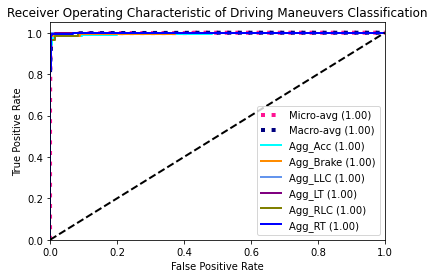

In [39]:
#roc_auc(model)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


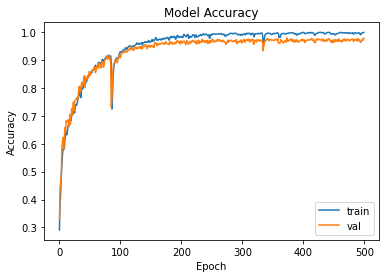

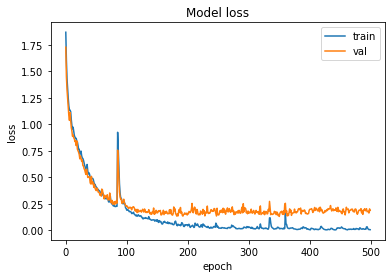

In [40]:
acc_loss_plot(model)

In [36]:
dataset source: 